In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('MuMu_dataset/MuMu_dataset_single-label.csv')

In [3]:
df.head(5)

,amazon_id,album_mbid,MSD_track_id,recording_mbid,artist_mbid,genres
0,B0018ZB6ZO,0164b5ce-42f8-46bf-b140-61ecd2ed449e,TRYDUXK12903CE0C37,66dd470f-4c4f-4caa-b8d4-2ebc80a83cb6,7434b85a-4a06-42ba-9e1d-9c568c044842,Dance & Electronic
1,B0018ZB6ZO,0164b5ce-42f8-46bf-b140-61ecd2ed449e,TRGWXYX128F426E27F,b45aef36-c3a3-42f2-90fb-728e8b3c54a2,7434b85a-4a06-42ba-9e1d-9c568c044842,Dance & Electronic
2,B000003HGR,7fe6e337-9115-3719-855b-0441c42a2c36,TRVMIIJ12903CDBF1D,36b15f42-b441-4d64-8ba9-ca264ed1c6f1,1b54e90c-638e-4fdd-a20e-4ab09db9fdaf,Alternative Rock
3,B000003HGR,7fe6e337-9115-3719-855b-0441c42a2c36,TRDHJVA128F9335634,279fabb3-830e-4d04-86d5-53668bc42bfa,1b54e90c-638e-4fdd-a20e-4ab09db9fdaf,Alternative Rock
4,B000003HGR,7fe6e337-9115-3719-855b-0441c42a2c36,TRKDLHL12903CDBF32,381b90e1-c07f-4a53-be8c-6a2107d7a17f,1b54e90c-638e-4fdd-a20e-4ab09db9fdaf,Alternative Rock


In [4]:
len(df)

12087

In [5]:
df2 = pd.read_csv('MuMu_dataset/MuMu_dataset_multi-label.csv')
len(df2)

147295

In [45]:
df['album_mbid'].nunique()

2321

In [61]:
df['genres'].nunique()

16

In [79]:
# DATA CLEANING
df_reduced = df.drop_duplicates(['amazon_id', 'album_mbid'])
top_genres = list(df_reduced['genres'].value_counts()[-4:].index)
df_top_genres = df_reduced[~df_reduced['genres'].isin(top_genres)]
df_top_genres['genres'].value_counts()

Dance & Electronic    518
Rock                  391
Jazz                  266
Alternative Rock      260
Country               151
Pop                   139
R&B                   127
Metal                 119
Rap & Hip-Hop         103
Latin Music            95
Blues                  66
Folk                   32
Name: genres, dtype: int64

In [80]:
len(df_top_genres)

2267

In [65]:
df.groupby('amazon_id')['genres'].count()

amazon_id
B00000048F     2
B00000058F     1
B0000009P1     9
B000000BTN    13
B000000FJS     6
              ..
B00H7RETXS     3
B00I18QNCW     8
B00J3D34QM    19
B00JVSIMLQ     7
B00KE5M5IQ     3
Name: genres, Length: 2321, dtype: int64

In [49]:
df['genres'].value_counts()

Rock                  2362
Dance & Electronic    2329
Alternative Rock      1497
Jazz                  1146
Metal                  733
Pop                    675
Rap & Hip-Hop          662
R&B                    650
Country                636
Latin Music            553
Blues                  437
Folk                   149
Reggae                 102
New Age                 86
Classical               41
Gospel                  29
Name: genres, dtype: int64

In [88]:
df_img = pd.read_json('MuMu_dataset/amazon_metadata_MuMu.json')

In [39]:
url = df_img['imUrl'][1]

In [40]:
from PIL import Image
import cv2
import requests
from io import BytesIO

response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [41]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

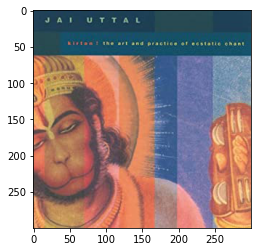

In [42]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [43]:
np.array(img).flatten()

array([ 37,  69,  92, ..., 239, 185,  89], dtype=uint8)

In [44]:
img.size

(300, 300)

In [81]:
df_top_genres

,amazon_id,album_mbid,MSD_track_id,recording_mbid,artist_mbid,genres
0,B0018ZB6ZO,0164b5ce-42f8-46bf-b140-61ecd2ed449e,TRYDUXK12903CE0C37,66dd470f-4c4f-4caa-b8d4-2ebc80a83cb6,7434b85a-4a06-42ba-9e1d-9c568c044842,Dance & Electronic
2,B000003HGR,7fe6e337-9115-3719-855b-0441c42a2c36,TRVMIIJ12903CDBF1D,36b15f42-b441-4d64-8ba9-ca264ed1c6f1,1b54e90c-638e-4fdd-a20e-4ab09db9fdaf,Alternative Rock
20,B0000564CN,d825b1ab-e260-3eb7-b486-5cb58ba0391f,TRPDZTD12903CBFC4B,aaf7c510-dc3d-4d39-81b0-81acf226fa09,570938b4-8fe5-44f9-ab43-9438feb03c6f,R&B
23,B00008CH90,47742269-fb1e-3fc0-a3c2-943f6095563d,TRNLZDY128F92FFBA6,259930ca-8e3c-42c8-93f1-b6656c9c9c77,e2d38070-361c-43f2-bca3-d08c54222761,R&B
30,B00014TJ52,a48b6911-9bd9-4711-a6c3-bdfb5a8c7a5f,TRNONQN12903CFE927,228ca23b-e8a3-4a1f-b3c0-6cab083b029c,89ad4ac3-39f7-470e-963a-56509c546377,Dance & Electronic
...,...,...,...,...,...,...
12063,B000EHRXMC,31e9d90b-e859-3f3e-a9c7-6af213b9b1d9,TRSHRQD128F14AAFDD,a0bac10d-274f-46cb-966f-ea2e9f940fdc,ac865b2e-bba8-4f5a-8756-dd40d5e39f46,Rock
12065,B00004UGTC,e9398949-8c87-4244-aaee-d3d4e1de68c3,TRRTAUV128F149F9D9,57f8dc06-ee6a-44c3-b547-9e091310ec1a,bbd11954-09aa-42af-9505-998d6bdc0b99,Jazz
12067,B0001J3W3C,6daf17da-a199-4b09-a72c-d3568564c8d1,TRDXQJT128EF34A45A,f8ef7a12-1eb6-4325-b814-2be4dffbe47a,2cd95baa-4043-4522-9c0a-dadbbf1cfbf6,Jazz
12076,B000GRU732,f9dd2e53-45f6-3ed1-b7bb-090c9e5abbeb,TRTNRYO128F4244820,52b32794-0ee1-4073-831c-3e8b75102052,8ef27ebb-f741-4ddf-bf5d-61a6bb981eca,Dance & Electronic


In [83]:
df[df['amazon_id'] == 'B09QRMPBPB']

,amazon_id,album_mbid,MSD_track_id,recording_mbid,artist_mbid,genres


In [100]:
display(df_img)

,title,price,imUrl,amazon_id,related,categories,salesRank,brand
0,Comfort Zone,20.69,http://ecx.images-amazon.com/images/I/51fdvJLW...,1458389375,"{'also_bought': [], 'buy_after_viewing': []}","[[CDs & Vinyl, Jazz], [CDs & Vinyl, Pop]]",NaN,NaN
1,Kirtan,22.94,http://ecx.images-amazon.com/images/I/51GGK0zo...,1591791065,"{'also_bought': ['B001QSER54', 'B00020HDXU', '...","[[CDs & Vinyl, Classical], [CDs & Vinyl, New A...",{'Music': 89340},NaN
2,Rough Guide to Gypsy Music,21.50,http://ecx.images-amazon.com/images/I/51Li1pqK...,1906063443,"{'also_bought': ['B0001AV59O'], 'buy_after_vie...","[[CDs & Vinyl, Christian], [CDs & Vinyl, Pop],...",{'Music': 337752},NaN
3,Making Lite of Myselrf,16.78,http://ecx.images-amazon.com/images/I/51eW8XLF...,1929243766,"{'also_bought': ['B00000AE86', 'B001PWY4I6', '...","[[CDs & Vinyl, Comedy & Spoken Word], [CDs & V...",{'Music': 16578},NaN
4,In the Quiet,21.15,http://ecx.images-amazon.com/images/I/41F5hqeP...,1930864159,"{'also_bought': [], 'buy_after_viewing': []}","[[CDs & Vinyl, Christian, Pop & Contemporary],...",{'Music': 102498},NaN
...,...,...,...,...,...,...,...,...
31466,NaN,NaN,http://ecx.images-amazon.com/images/I/21o%2B73...,B00JVSIMLQ,"{'also_bought': [], 'buy_after_viewing': []}","[[CDs & Vinyl, Latin Music, Latin Pop]]",{'Music': 1217044},NaN
31467,NaN,NaN,http://ecx.images-amazon.com/images/I/316q03mN...,B00KDL9TTE,"{'also_bought': [], 'buy_after_viewing': []}","[[CDs & Vinyl, Pop, Easy Listening]]",NaN,NaN
31468,NaN,34.45,http://ecx.images-amazon.com/images/I/51UgnZe%...,B00KE5M5IQ,"{'also_bought': [], 'bought_together': ['B00K6...","[[CDs & Vinyl, Latin Music, Latin Pop]]",{'Music': 7262},NaN
31469,NaN,15.39,http://ecx.images-amazon.com/images/I/51obnT4n...,B00KG10ZXU,"{'also_bought': [], 'also_viewed': ['B00000265...","[[CDs & Vinyl, Broadway & Vocalists], [CDs & V...",{'Music': 15508},NaN


In [101]:
df_in_the_quiet = df_img[df_img['title']=='In the Quiet']

In [110]:
df_img.loc[4,:]['imUrl']

'http://ecx.images-amazon.com/images/I/41F5hqePyOL._SY300_.jpg'

In [111]:
df_full = pd.read_csv('MuMu_dataset/MuMu_dataset_multi-label.csv')

,amazon_id,album_mbid,MSD_track_id,recording_mbid,artist_mbid,genres
0,B00005YQOV,77944b8c-f753-4c7c-84ba-a48fbf518667,TRJIKJU128F930BF28,68c38213-65ba-4c1e-ac20-76883b512993,0a6f37da-2a2a-4308-896a-7c34b968b0b3,"Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Mode..."
1,B00005YQOV,77944b8c-f753-4c7c-84ba-a48fbf518667,TRLCVKT128F930BF18,f5c25488-4fbc-4ade-9cd4-431ae3fe3737,0a6f37da-2a2a-4308-896a-7c34b968b0b3,"Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Mode..."
2,B00005YQOV,77944b8c-f753-4c7c-84ba-a48fbf518667,TRBQSIG128F930BEFC,e76bbfcc-f94a-425d-bf13-d4e8d32df173,0a6f37da-2a2a-4308-896a-7c34b968b0b3,"Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Mode..."
3,B00005YQOV,77944b8c-f753-4c7c-84ba-a48fbf518667,TRGQLER128F930BF59,9def0715-4be3-4755-b546-f0335e03447b,0a6f37da-2a2a-4308-896a-7c34b968b0b3,"Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Mode..."
4,B00005YQOV,77944b8c-f753-4c7c-84ba-a48fbf518667,TRQPGRM128F930BEEA,9fe52229-a318-499e-af96-0903294366b1,0a6f37da-2a2a-4308-896a-7c34b968b0b3,"Vocal Jazz,Jazz,Traditional Vocal Pop,Pop,Mode..."
...,...,...,...,...,...,...
147290,B00004NH92,31d692d2-c9a5-3637-bc59-9becba83bbd3,TRNEHCV128F930CE23,533f353a-5ebe-409e-b854-92c34b9c6619,b8282669-ab13-40c2-a01e-acbb9cf64981,"R&B,Jazz,Pop,Dance & Electronic,Jazz Jam Bands..."
147291,B00004NH92,31d692d2-c9a5-3637-bc59-9becba83bbd3,TRXXOQB128F930CE17,7381e598-78c7-4eb8-88f2-1b38eb439014,b8282669-ab13-40c2-a01e-acbb9cf64981,"R&B,Jazz,Pop,Dance & Electronic,Jazz Jam Bands..."
147292,B00004NH92,31d692d2-c9a5-3637-bc59-9becba83bbd3,TRQHKOT128F930CE20,1cc31fb3-24d2-4460-804c-968446af5677,b8282669-ab13-40c2-a01e-acbb9cf64981,"R&B,Jazz,Pop,Dance & Electronic,Jazz Jam Bands..."
147293,B00004NH92,31d692d2-c9a5-3637-bc59-9becba83bbd3,TRTAIPQ128F930CE1B,ad8cede6-a437-4a2c-8a69-7a92b7e486f0,b8282669-ab13-40c2-a01e-acbb9cf64981,"R&B,Jazz,Pop,Dance & Electronic,Jazz Jam Bands..."
